<a href="https://colab.research.google.com/github/cabamarcos/Captcha_recognition/blob/main/solofaltantes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importación de las herramientas necesarias

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from collections import Counter
from pathlib import Path
import time
import random

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from google.colab.patches import cv2_imshow


import matplotlib.image as mpimg
%matplotlib inline

from sklearn.metrics import confusion_matrix
import itertools

from keras.utils import to_categorical# convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import LabelBinarizer

# Análisis exploratorio de los datos

In [2]:
# Especifica la ruta a la carpeta que contiene las imágenes
image_folder = Path('/content/')

# Obtiene la lista de imágenes en la carpeta
images = list(image_folder.glob("*.png")) + list(image_folder.glob("*.jpg"))

# Store all the characters in a set
characters = set()

# Store all the labels in a set
labels = set()

# Create a list of dictionaries to store the image-label pair info
dataset = []

# Iterate over the dataset and store the
# information needed
for img_path in images:
    # 1. Get the label associated with each image
    label = img_path.stem  # Utiliza .stem para obtener el nombre del archivo sin la extensión

    # label = img_path.name.split(".png")[0]
    # 2. Store the length of this captcha
    captcha_length = len(label)
    # 3. Store the image-label pair info
    dataset.append({"img_path": str(img_path), "label": label})
    # 4. Store the characters present
    characters.update(set(label))
    # 5. Store the labels
    labels.add(label)

# Convert the list of dictionaries into a DataFrame
dataset = pd.DataFrame(dataset)

print("Number of images found:", len(images))
print("Number of labels found:", len(labels))
print("Number of unique characters:", len(characters))
print("Characters present:", characters)


Number of images found: 1019
Number of labels found: 1019
Number of unique characters: 19
Characters present: {'d', 'w', '5', '8', '4', 'b', '6', 'x', 'n', '2', 'e', '7', 'p', 'y', 'c', '3', 'g', 'm', 'f'}


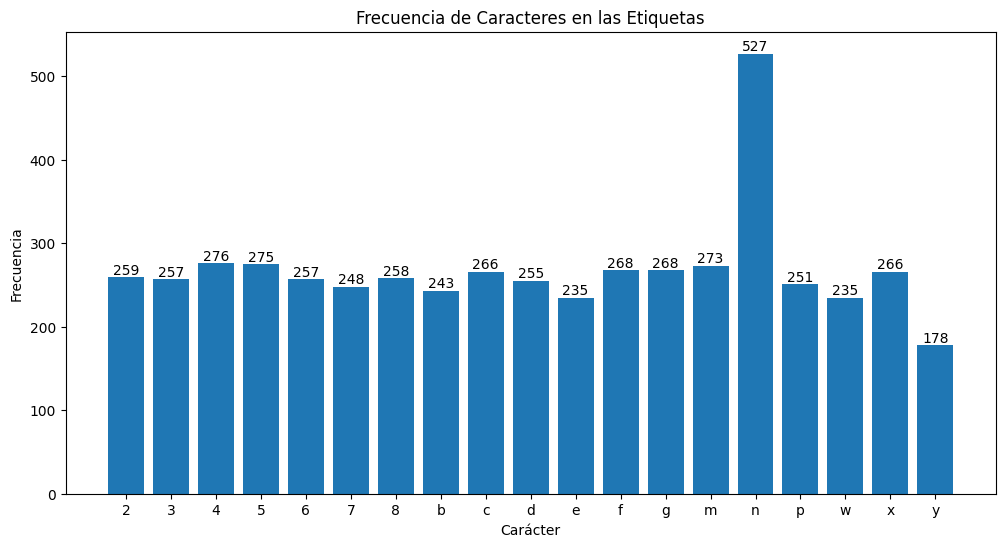

In [3]:
# Calcula la frecuencia de cada carácter
character_counts = Counter("".join(dataset["label"]))

# Convierte los resultados en dos listas separadas para plotear
characters = list(character_counts.keys())
counts = list(character_counts.values())

# Ordena los caracteres alfabéticamente
characters, counts = zip(*sorted(zip(characters, counts)))

# Crea la gráfica de barras
plt.figure(figsize=(12, 6))
plt.bar(characters, counts)

# Agrega etiquetas con el número exacto en cada barra
for i in range(len(characters)):
    plt.text(characters[i], counts[i], str(counts[i]), ha='center', va='bottom')

plt.xlabel("Carácter")
plt.ylabel("Frecuencia")
plt.title("Frecuencia de Caracteres en las Etiquetas")
plt.show()

# 1ª parte

## Primeros pasos

In [4]:
np.random.seed(2)
sns.set(style='white', context='notebook', palette='deep')

### División de las imágenes

La siguiente parte del código, procesa una lista de imágenes utilizando la biblioteca OpenCV para aplicar umbralización adaptativa, dilatación y otras operaciones vistas en el apartado anterior. Después, separa las imágenes en 5 partes iguales y luego recopila las imágenes resultantes en una lista x y sus etiquetas en una lista y.

In [5]:
# Definir un kernel de convolución de 3x1 con valores enteros sin signo
kernel = np.ones((3, 1), np.uint8)

# Definir el tipo de borde a utilizar
borderType = cv2.BORDER_CONSTANT

# Función para aplicar relleno a una imagen
def pad(src):
    # Calcular la cantidad de píxeles de relleno para la parte superior e inferior
    top = int(0.05 * src.shape[0])  # El 5% de la altura de la imagen
    bottom = top

    # Calcular la cantidad de píxeles de relleno para la parte izquierda y derecha
    left = int(0.15 * src.shape[1])  # El 15% de la anchura de la imagen
    right = left

    # Aplicar el relleno a la imagen de origen utilizando cv2.copyMakeBorder
    des = cv2.copyMakeBorder(src, top, bottom, left + 1, right, borderType, None, 255)

    # Invertir los colores de la imagen utilizando cv2.bitwise_not
    return cv2.bitwise_not(des)

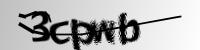

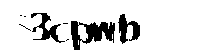

In [6]:
im = cv2.imread(str('3cpwb.png'), 0)
cv2_imshow(im)
# Aplicar un umbral adaptativo a la imagen utilizando el método GAUSSIAN_C
threshold = cv2.adaptiveThreshold(im, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 199, 5)

# Dilatar la imagen umbralizada utilizando un kernel definido en algún lugar anterior del código
erosion = cv2.dilate(threshold, kernel, iterations=2)

cv2_imshow(erosion)


In [7]:
images = list(image_folder.glob("*.png")) + list(image_folder.glob("*.jpg"))
x = []  # Lista para almacenar las imágenes procesadas
y = []  # Lista para almacenar las etiquetas correspondientes

# Iterar a través de la lista de imágenes
for image in images:
    # Cargar la imagen en escala de grises (canal único)
    im = cv2.imread(str(image), 0)

    # Aplicar un umbral adaptativo a la imagen utilizando el método GAUSSIAN_C
    threshold = cv2.adaptiveThreshold(im, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 199, 5)

    # Dilatar la imagen umbralizada utilizando un kernel definido en algún lugar anterior del código
    erosion = cv2.dilate(threshold, kernel, iterations=1)

    # Obtener el nombre de archivo de la imagen
    s = str(image)

    # Dividir la imagen erosionada en 5 partes iguales y procesar cada parte con la función 'pad'
    for i in range(5):
        # Agregar la imagen procesada a la lista 'x'
        x.append(pad(erosion[:, (30 + 23 * i):(30 + 23 * (i + 1))]))

        # Agregar la etiqueta correspondiente (carácter o dígito) a la lista 'y'
        y.append(s[-9 + i])


Podemos ver un ejemplo

'f'

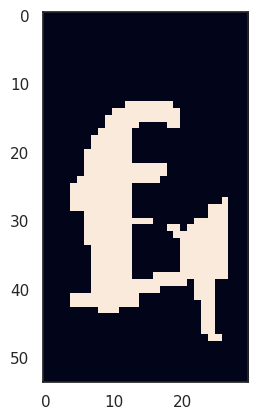

In [8]:
plt.imshow(x[190])
y[190]

Vamos a ver ejemplos de como ha funcionado nuestra división

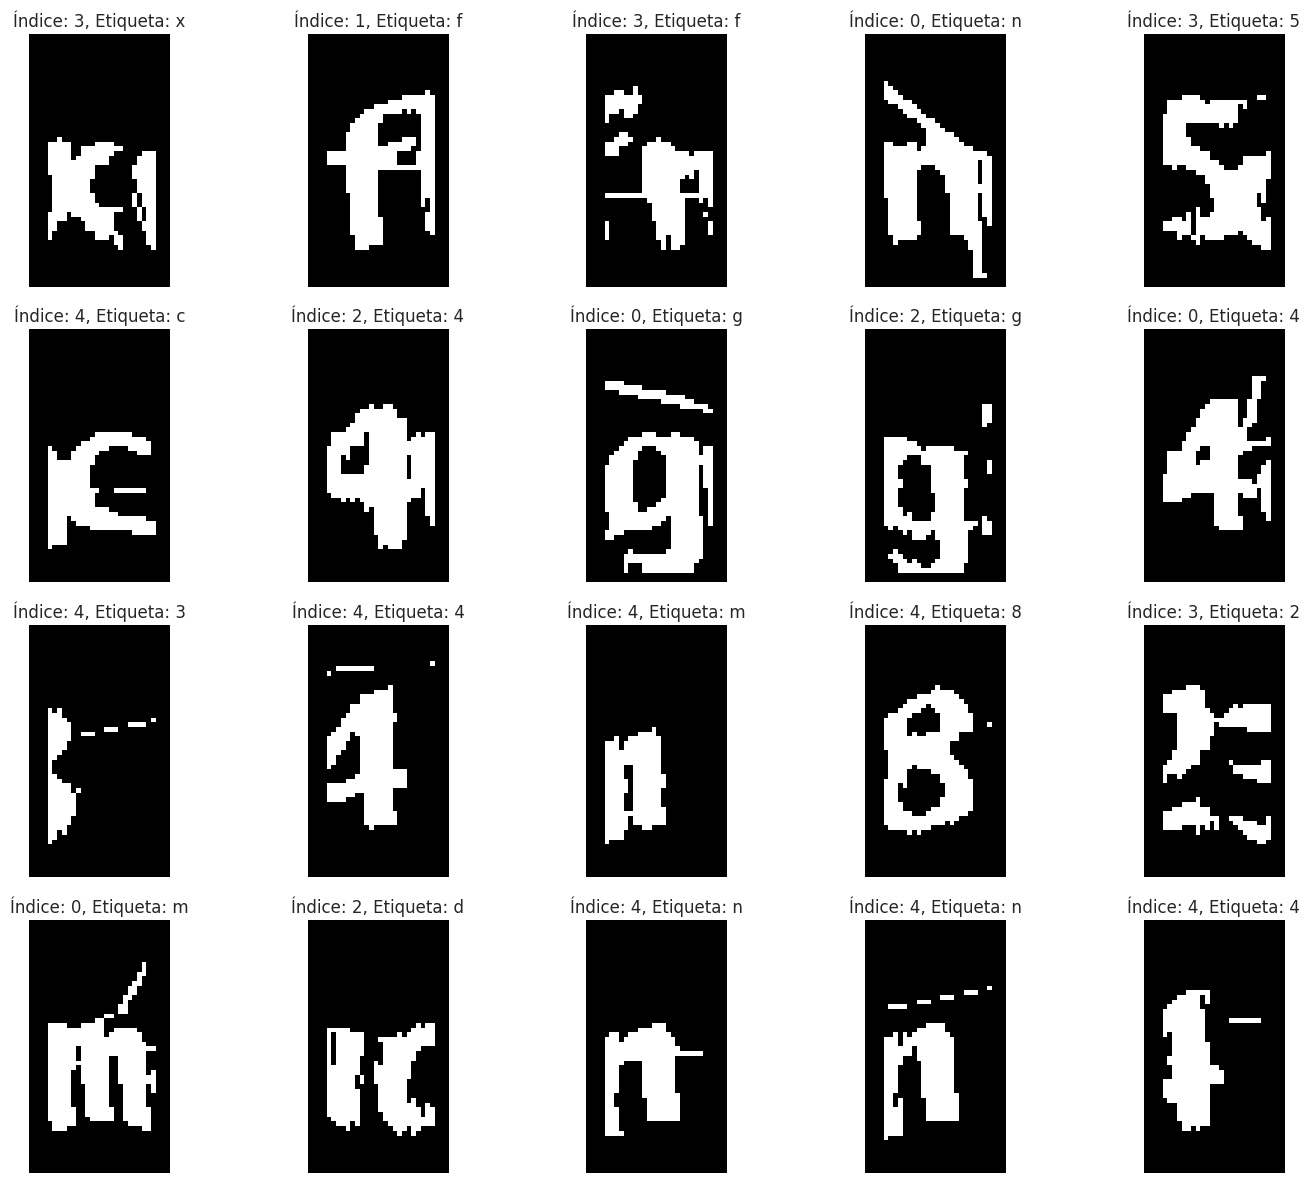

In [9]:
# Número de ejemplos a mostrar
num_examples = 20

# Genera índices aleatorios para seleccionar ejemplos
random_indices = random.sample(range(len(x)), num_examples)

# Configuración para la disposición de subplots
num_rows = 4  # Cambia esto según la cantidad de filas deseadas
num_cols = 5  # Cambia esto según la cantidad de columnas deseadas

# Crea una figura con subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 12))

for i, idx in enumerate(random_indices):
    row = i // num_cols
    col = i % num_cols
    ax = axs[row, col]

    ax.imshow(x[idx], cmap='gray')
    ax.set_title(f'Índice: {idx%5}, Etiqueta: {y[idx]}')
    ax.axis('off')

# Asegura que los subplots vacíos no se muestren
for i in range(num_examples, num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axs[row, col].axis('off')

plt.tight_layout()
plt.show()


In [10]:
x=np.array(x)
y=np.array(y)
data=np.reshape(x,(-1,54,30,1))

# Caracteres faltantes

## One hot encoding


In [11]:
images_1 = list(image_folder.glob("*.png")) + list(image_folder.glob("*.jpg"))

imagenes = []
etiquetas = []
# Iterar a través de la lista de imágenes
for image in images_1:
    # Cargar la imagen en escala de grises (canal único)
    im = cv2.imread(str(image), 0)

    # Aplicar un umbral adaptativo a la imagen utilizando el método GAUSSIAN_C
    threshold = cv2.adaptiveThreshold(im, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 199, 5)

    # Dilatar la imagen umbralizada utilizando un kernel definido en algún lugar anterior del código
    erosion = cv2.dilate(threshold, kernel, iterations=1)

    # Obtener el nombre de archivo de la imagen
    s = str(image)

    # Dividir la imagen erosionada en 5 partes iguales y procesar cada parte con la función 'pad'
    for i in range(5):
        # Agregar la imagen procesada a la lista 'x'
        imagenes.append(pad(erosion[:, (30 + 23 * i):(30 + 23 * (i + 1))]))

        # Agregar la etiqueta correspondiente (carácter o dígito) a la lista 'y'
        etiquetas.append(s[-9 + i])

ruta_carpeta = "/content/Faltantes"
for archivo in os.listdir(ruta_carpeta):
  if archivo.endswith(".png") or archivo.endswith(".jpg"):
    # Extraer etiqueta del nombre del archivo
    etiqueta = archivo[3]

    # Cargar la imagen y convertirla a escala de grises
    ruta_completa = os.path.join(ruta_carpeta, archivo)
    imagen = cv2.imread(ruta_completa, cv2.IMREAD_GRAYSCALE)

    # Recortamos la imagen para quitar informacion irrelevante
    inicio_x, final_x = 300, 850
    inicio_y, final_y = 150, 800

    # Realizar el recorte
    imagen_recortada = imagen[inicio_y:final_y, inicio_x:final_x]

    # Añadir la imagen y la etiqueta a las listas
    imagenes.append(imagen_recortada)
    etiquetas.append(etiqueta)

# Resizeamos las imagenes para que tengan la misma forma que las demas: (54,30)
nuevas_imagenes = []

for imagen in imagenes:
    # Redimensionar la imagen
    nueva_imagen = cv2.resize(imagen, (30, 54))  # el formato es (ancho, alto)
    #cv2.bitwise_not(nueva_imagen)
    nuevas_imagenes.append(nueva_imagen)

# Convertir a matrices numpy
imagenes = np.array(nuevas_imagenes)
etiquetas = np.array(etiquetas)
# Realizar one-hot encoding utilizando LabelBinarizer
lb = LabelBinarizer()
etiquetas_encoded = lb.fit_transform(etiquetas)

In [12]:
print("Forma de la imagen en la posición 5500:", imagenes[5500].shape)


Forma de la imagen en la posición 5500: (54, 30)


In [13]:
print("Forma de la imagen en la posición 1:", imagenes[1].shape)


Forma de la imagen en la posición 1: (54, 30)


In [14]:
print(lb.classes_)

['1' '2' '3' '4' '5' '6' '7' '8' '9' 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i'
 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r' 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']


In [15]:
model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (54,30,1)))
model.add(Conv2D(filters = 16, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(35, activation = "softmax"))

In [16]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau


In [17]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-08, centered=False)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

### Separación de datos

In [18]:
X_train2, X_val2, Y_train2, Y_val2 = train_test_split(imagenes, etiquetas_encoded, test_size = 0.1, random_state= 2, stratify=etiquetas)
X_train2=X_train2/255.0
X_val2=X_val2/255.0

## Data augmentation

In [19]:
print("Forma de X_train2:", X_train2.shape)

Forma de X_train2: (5377, 54, 30)


In [20]:
import numpy as np

# Añadir una dimensión para el canal de color (escala de grises)
X_train2 = np.expand_dims(X_train2, axis=-1)
X_val2 = np.expand_dims(X_val2, axis=-1)

#Verificar la nueva forma de X_train2
print("Nueva forma de X_train2:", X_train2.shape)


Nueva forma de X_train2: (5377, 54, 30, 1)


In [21]:
print("Nueva forma de X_train2:", X_val2.shape)

Nueva forma de X_train2: (598, 54, 30, 1)


In [22]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=5,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = False, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train2)

## Fitting

In [23]:
batch_size = 86

In [24]:
to= time.time()
history = model.fit(datagen.flow(X_train2,Y_train2, batch_size=86),
                              epochs =  40, validation_data = (X_val2,Y_val2),
                              verbose = 1, steps_per_epoch=X_train2.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])
tf = time.time()

print("El tiempo total es: ", tf-to)

Epoch 1/40
62/62 [==============================] - 54s 830ms/step - loss: 2.8690 - accuracy: 0.1576 - val_loss: 1.6364 - val_accuracy: 0.4114 - lr: 0.0010
Epoch 2/40
62/62 [==============================] - 49s 801ms/step - loss: 1.9018 - accuracy: 0.3944 - val_loss: 1.0804 - val_accuracy: 0.6488 - lr: 0.0010
Epoch 3/40
62/62 [==============================] - 45s 715ms/step - loss: 1.4987 - accuracy: 0.5328 - val_loss: 0.8654 - val_accuracy: 0.7391 - lr: 0.0010
Epoch 4/40
62/62 [==============================] - 55s 887ms/step - loss: 1.1933 - accuracy: 0.6246 - val_loss: 0.9695 - val_accuracy: 0.6990 - lr: 0.0010
Epoch 5/40
62/62 [==============================] - 46s 737ms/step - loss: 1.0075 - accuracy: 0.6925 - val_loss: 0.5748 - val_accuracy: 0.8177 - lr: 0.0010
Epoch 6/40
62/62 [==============================] - 45s 724ms/step - loss: 0.8841 - accuracy: 0.7254 - val_loss: 0.5252 - val_accuracy: 0.8244 - lr: 0.0010
Epoch 7/40
62/62 [==============================] - 43s 689ms/st

Mejor época de entrenamiento: 38, Mejor accuracy de entrenamiento: 0.9472689628601074
Mejor época de validación: 35, Mejor accuracy de validación: 0.9548494815826416


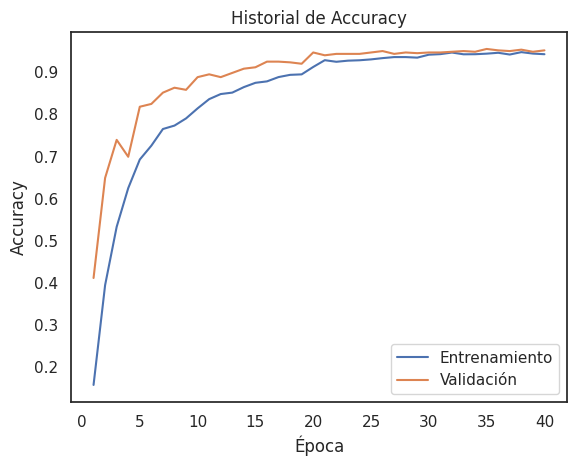

In [25]:
# Obtiene el accuracy de entrenamiento y validación de cada época
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Encuentra la época con el mejor accuracy en el conjunto de entrenamiento y validación
best_epoch_train = train_accuracy.index(max(train_accuracy))
best_accuracy_train = max(train_accuracy)

best_epoch_val = val_accuracy.index(max(val_accuracy))
best_accuracy_val = max(val_accuracy)

# Imprime la época con el mejor accuracy y su valor en entrenamiento y validación
print(f"Mejor época de entrenamiento: {best_epoch_train + 1}, Mejor accuracy de entrenamiento: {best_accuracy_train}")
print(f"Mejor época de validación: {best_epoch_val + 1}, Mejor accuracy de validación: {best_accuracy_val}")

# Grafica el accuracy en el conjunto de entrenamiento y validación a lo largo de las épocas
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Entrenamiento')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validación')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Historial de Accuracy')
plt.show()

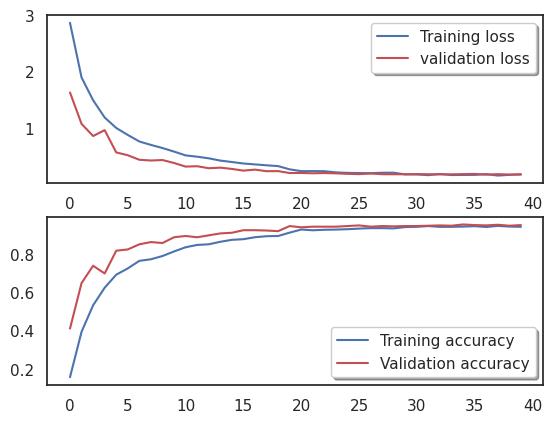

In [26]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

## Errores detectados

19/19 [==============================] - 2s 64ms/step


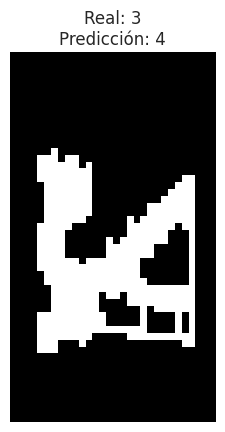

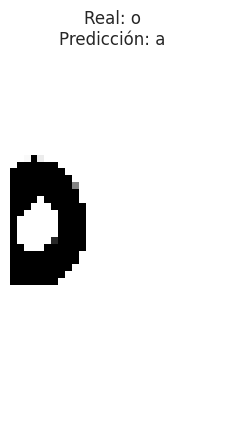

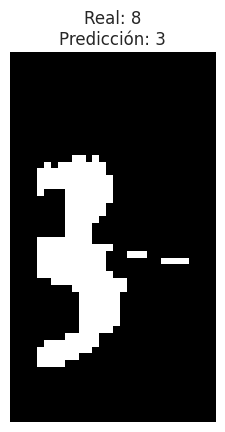

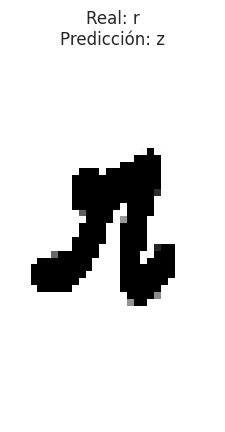

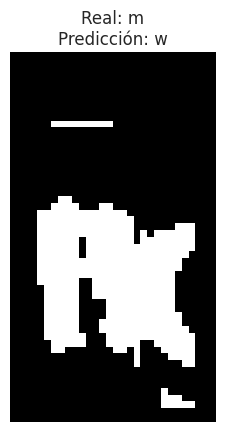

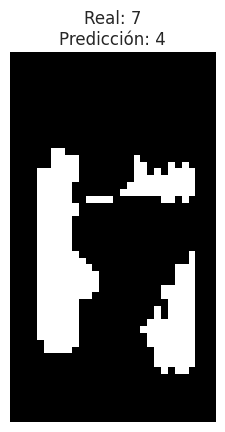

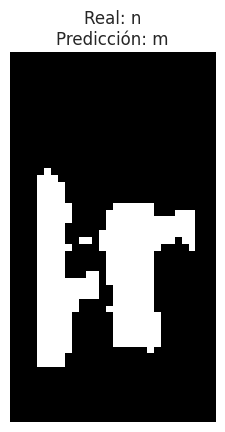

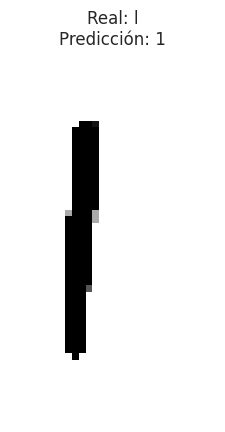

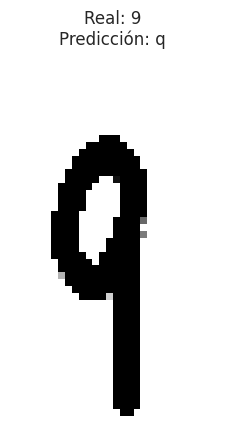

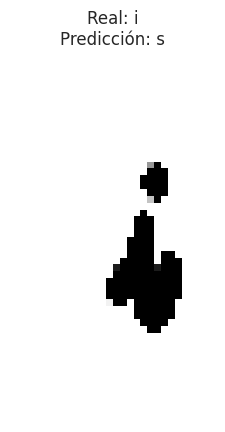

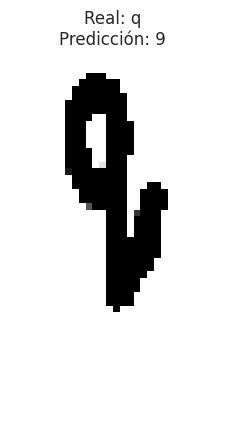

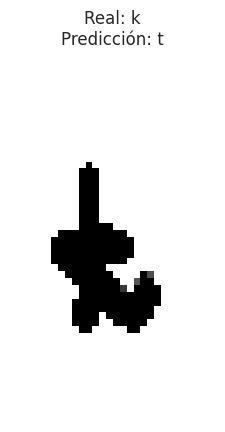

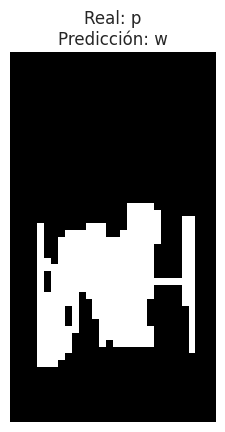

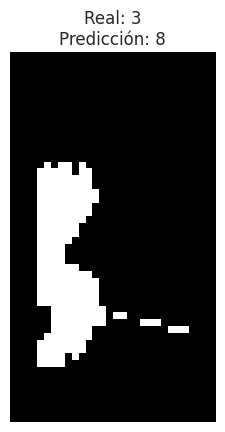

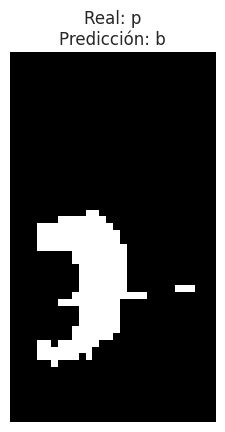

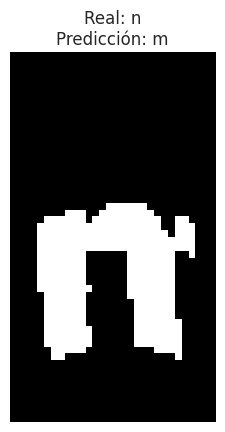

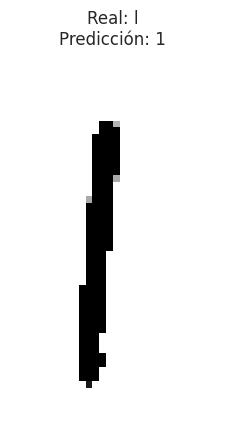

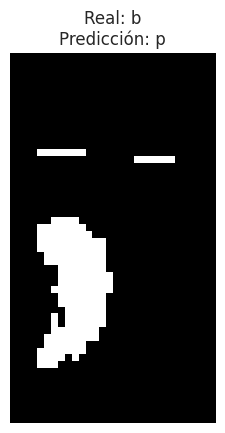

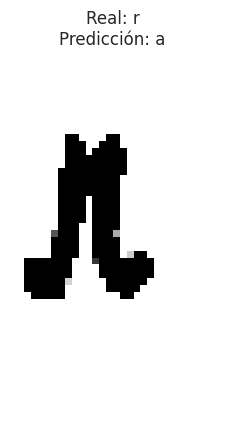

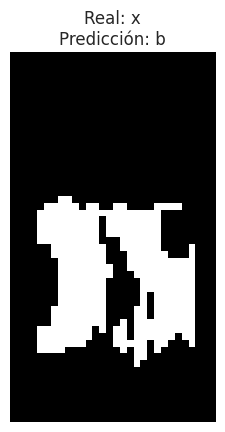

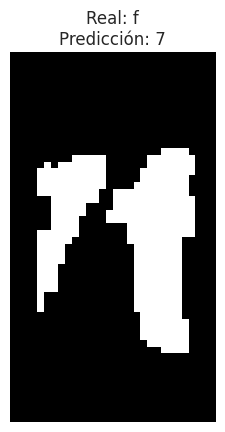

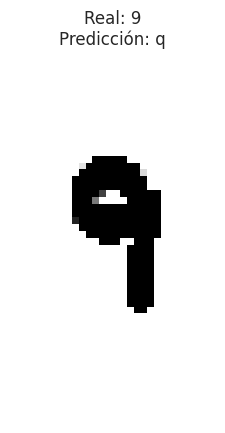

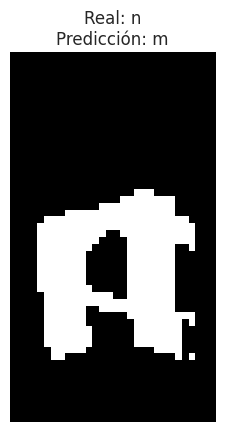

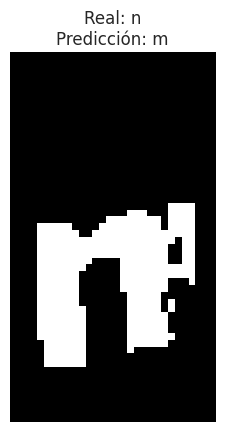

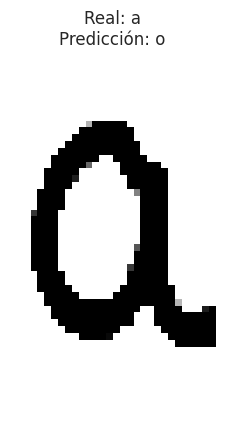

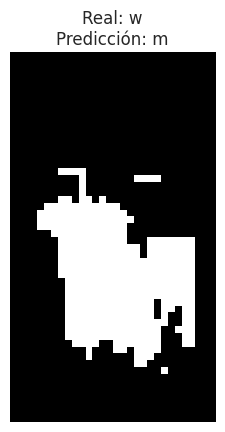

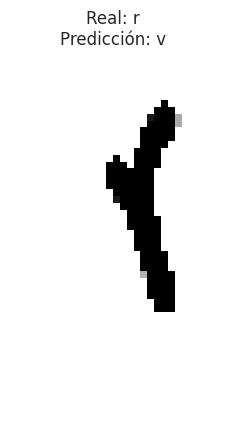

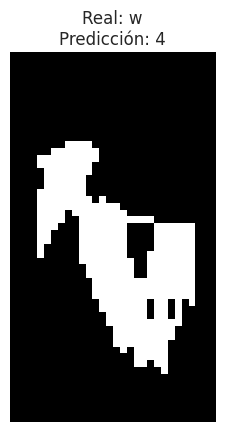

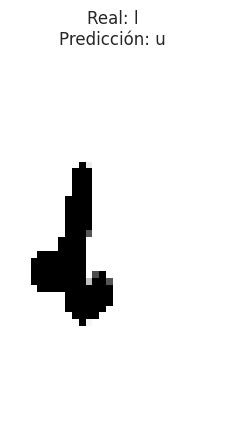

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Image

# Mapeo de índices a etiquetas reales
etiquetas_reales = np.array(['1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i',
 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'])

# Obtén las predicciones en el conjunto de validación
predicciones_val = model.predict(X_val2)

# Encuentra los índices de las predicciones incorrectas
indices_errores = np.where(np.argmax(predicciones_val, axis=1) != np.argmax(Y_val2, axis=1))[0]

# Muestra todas las imágenes de predicciones incorrectas
for i, indice_error in enumerate(indices_errores):
    # Obtén la imagen y las etiquetas correspondientes
    imagen = X_val2[indice_error]
    etiqueta_real = etiquetas_reales[np.argmax(Y_val2[indice_error])]
    etiqueta_predicha = etiquetas_reales[np.argmax(predicciones_val[indice_error])]

    # Muestra la imagen sin cambios en el tamaño
    plt.imshow(imagen, cmap='gray')  # Usar cmap='gray' si las imágenes son en escala de grises
    plt.title(f'Real: {etiqueta_real}\nPredicción: {etiqueta_predicha}')
    plt.axis('off')
    plt.show()


## Test con captchas completos

Ahora analizaremos en las imagenes completas

In [28]:
l = ['1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i',
 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
def captcha(img,p):
    im=cv2.imread(str(img),0)
    threshold=cv2.adaptiveThreshold(im, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY, 199, 5)
    erosion =cv2.dilate(threshold,kernel,iterations=1)
    images=[]
    for i in range(5):
        images.append(pad(erosion[:,(30+23*i):(30+23*(i+1))]))
    images=np.reshape(images,(-1,54,30,1))
    pred=model.predict(images)
    pred=np.argmax(pred,axis = 1)
    predicted=str(l[pred[0]]+l[pred[1]]+l[pred[2]]+l[pred[3]]+l[pred[4]])
    if(p):
        print(predicted)
    if(predicted==img[-9:-4]):
        return 1
    return 0


In [29]:
images = list(image_folder.glob("*.png")) + list(image_folder.glob("*.jpg"))
t=0
for i in images:
    t+=captcha(str(i),False)

1/1 [==============================] - 0s 32ms/step


In [30]:
print("total images",len(images),"correctly identified",t)
print("Accuracy is",t/len(images))

total images 1019 correctly identified 947
Accuracy is 0.929342492639843


## Predicción con las nuevas imágenes


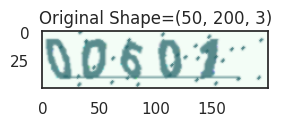

In [32]:
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

# Ruta de la imagen PNG
img_path = Path('Nuevos/oo6o1.png')

# Cargar la imagen
img = cv2.imread(str(img_path))

# Mostrar la imagen original
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Shape=' + str(img.shape))

plt.show()


## Nuevos

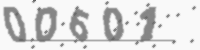

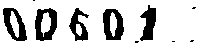

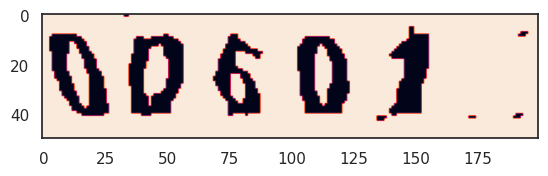

In [34]:
im = cv2.imread(str('Nuevos/oo6o1.png'), 0)
cv2_imshow(im)
# Aplicar un umbral adaptativo a la imagen utilizando el método GAUSSIAN_C
threshold = cv2.adaptiveThreshold(im, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 199, 5)

# Dilatar la imagen umbralizada utilizando un kernel definido en algún lugar anterior del código
erosion = cv2.dilate(threshold, kernel, iterations=2)

cv2_imshow(erosion)

plt.imshow(erosion)

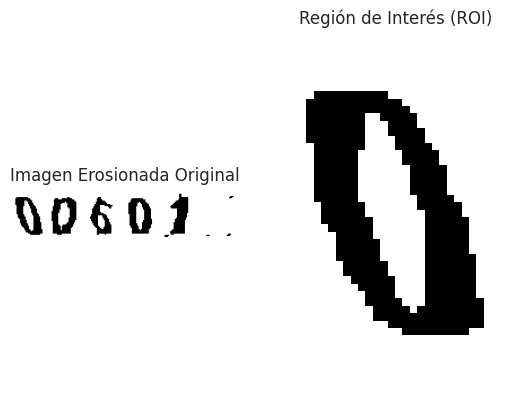

In [37]:
# Recortar la región de interés (ROI) desde el píxel 0 al 30 en ambas dimensiones
roi = erosion[:, 0:30]

# Mostrar la región de interés (ROI)
plt.subplot(122)
plt.imshow(roi, cmap='gray')
plt.title('Región de Interés (ROI)')
plt.axis('off')

# Mostrar las imágenes
plt.show()

## Nuevos 2

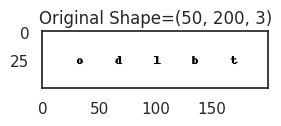

In [39]:
# Ruta de la imagen PNG
img_path = Path('Nuevos2/odlbt.png')

# Cargar la imagen
img = cv2.imread(str(img_path))

# Mostrar la imagen original
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Shape=' + str(img.shape))

plt.show()

Etiqueta: 0


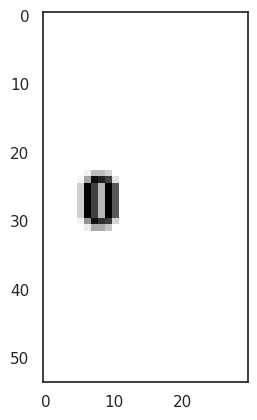

Etiqueta: 2


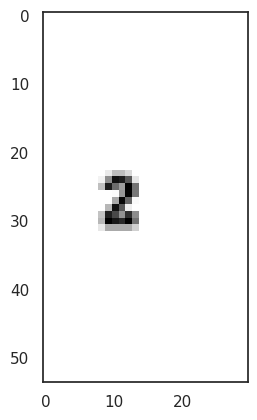

Etiqueta: s


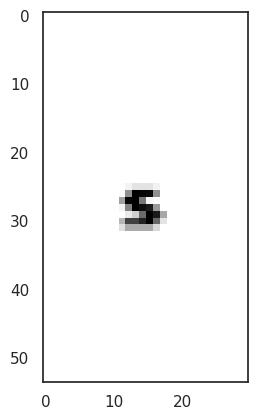

Etiqueta: o


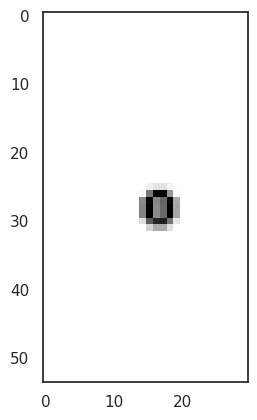

Etiqueta: 2


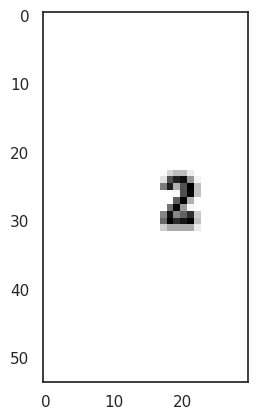

In [52]:
from keras.preprocessing.image import ImageDataGenerator

# Define la ruta de la carpeta que contiene las imágenes
image_folder = Path('/content/Nuevos2')

# Selecciona una imagen específica (mdp89.png en este caso)
image_name = "02so2.png"
image_path = image_folder / image_name

# Lista para almacenar las imágenes procesadas
imagenes = []

# Lista para almacenar las etiquetas correspondientes
labels = []

# Dimensiones deseadas para cada subdivisión
subdivision_height = 54
subdivision_width = 30

# Factor de ampliación para la zona de interés
scale_factor = 1  # Puedes ajustar este valor según tus necesidades

# Rango de píxeles en el eje horizontal para las subdivisiones
start_pixel = 25
end_pixel = 180

# Cargar la imagen en escala de grises (canal único)
im = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)

# Calcular los índices de inicio y fin para cada subdivisión
for i in range(5):
    start_index = int(start_pixel + (end_pixel - start_pixel) / 5 * i)
    end_index = int(start_pixel + (end_pixel - start_pixel) / 5 * (i + 1))

    # Ajustar la anchura a 30 y seleccionar la región de la imagen
    sub_image = im[:, start_index:end_index]

    # Ampliar la zona de interés mediante interpolación
    enlarged_sub_image = cv2.resize(sub_image, (subdivision_width * scale_factor, subdivision_height * scale_factor), interpolation=cv2.INTER_LINEAR)

    # Agregar la imagen procesada a la lista 'imagenes'
    imagenes.append(enlarged_sub_image)

    # Agregar la etiqueta correspondiente (carácter o dígito) a la lista 'labels'
    labels.append(image_path.name[i])

    # Imprimir la etiqueta y mostrar la subdivisión ampliada
    print(f"Etiqueta: {image_path.name[i]}")
    plt.imshow(enlarged_sub_image, cmap='gray')
    plt.show()



In [53]:
# Convertir las listas en arrays de numpy
x = np.array(imagenes)
y = np.array(labels)

# Expandir las dimensiones de 'x' para que coincida con el formato esperado por el modelo
x_expanded = np.expand_dims(x, axis=-1)



In [54]:
print("Forma actual de x:", x.shape)
print("Longitud de las etiquetas:", len(labels))


Forma actual de x: (5, 54, 30)
Longitud de las etiquetas: 5


In [55]:
# Obtener las predicciones del modelo
predicciones = model.predict(x_expanded)

# Imprimir las predicciones
for i, prediccion in enumerate(predicciones):
    print(f"Predicción para la etiqueta {y[i]}: {prediccion}")

1/1 [==============================] - 0s 35ms/step
Predicción para la etiqueta 0: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Predicción para la etiqueta 2: [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 1.0066686e-35 0.0000000e+00 0.0000000e+00 0.0000000e+00
 1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
Predicción para la etiqueta s: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Predicción para la etiqueta o: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Pr

In [56]:
# Convertir las predicciones one-hot a etiquetas
etiquetas_predichas = [etiquetas_reales[np.argmax(pred)] for pred in predicciones]

# Imprimir las etiquetas predichas para cada imagen
print("Etiquetas Predichas:")
print(etiquetas_predichas)


Etiquetas Predichas:
['v', 'v', 'z', 'z', 'v']
